In [25]:
import numpy as np
import math

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-07-20 13:45:14,103: Credentials are already in use. The existing account in the session will be replaced.


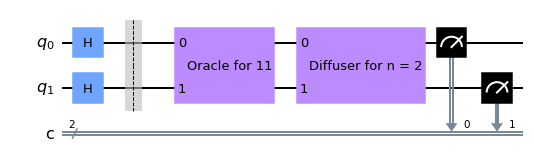

In [11]:
# We're going to implement Grover's Search in Qiskit!
# First, let's look at the case for when n = 2:

def oracle_two():
    q_oracle = QuantumCircuit(2)
    q_oracle.cz(0,1)
    q_oracle = q_oracle.to_gate()
    q_oracle.name = "Oracle for 11"
    return q_oracle
    
def diffuser_two():
    q_diffuser = QuantumCircuit(2)
    
    q_diffuser.h(0)
    q_diffuser.h(1)
    
    q_diffuser.z(0)
    q_diffuser.z(1)
    
    q_diffuser.cz(0,1)
    
    q_diffuser.h(0)
    q_diffuser.h(1)
    
    q_diffuser = q_diffuser.to_gate()
    q_diffuser.name = "Diffuser for n = 2"
    return q_diffuser
    

# We need 2 qubits (to search through)
n = 2

q_grover = QuantumCircuit(n,n)

# First, we need to form a uniform superposition of all possible states/options:
for i in range(n):
    q_grover.h(i)
    
q_grover.barrier()

q_grover.append(oracle_two(), range(n))
q_grover.append(diffuser_two(), range(n))

for i in range(n):
    q_grover.measure(i,i)

q_grover.draw()

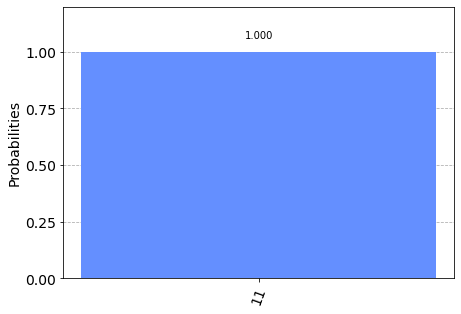

In [13]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(q_grover, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [14]:
# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_q_grover = transpile(q_grover, backend, optimization_level=3)
job = backend.run(transpiled_q_grover)
job_monitor(job, interval=2)

ibmqfactory.load_account:WARNING:2022-07-20 11:16:19,279: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_oslo
Job Status: job has successfully run


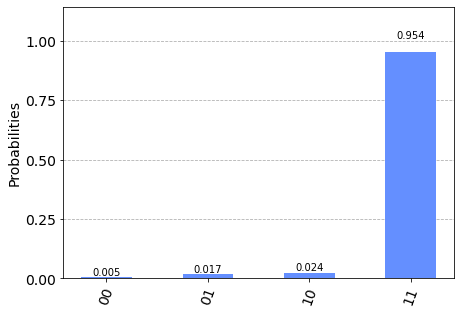

In [15]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

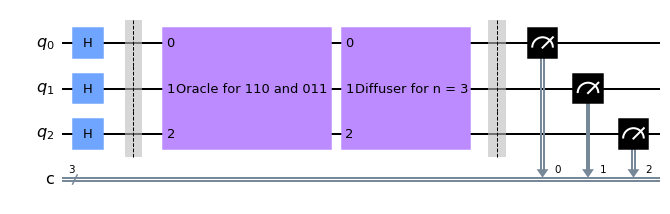

In [17]:
# Now, let's do this for a 3 Qubit system with 2 marked states
def oracle_three():
    q_oracle = QuantumCircuit(3)
    q_oracle.cz(0,1)
    q_oracle.cz(2,1)
    q_oracle = q_oracle.to_gate()
    q_oracle.name = "Oracle for 110 and 011"
    return q_oracle

def diffuser_three():
    q_diffuser = QuantumCircuit(3)
    
    for i in range(3):
        q_diffuser.h(i)

    for i in range(3):
        q_diffuser.x(i)
    
    # We need a Toffoli-z gate. We do this by first using a H gate, then a mct, and finally another H
    q_diffuser.h(2)
    q_diffuser.mct([0,1], 2)
    q_diffuser.h(2)
    
    for i in range(3):
        q_diffuser.x(i)
    
    for i in range(3):
        q_diffuser.h(i)

    q_diffuser = q_diffuser.to_gate()
    q_diffuser.name = "Diffuser for n = 3"
    return q_diffuser


# We need 3 qubits (to search through)
n = 3

q_grover = QuantumCircuit(n,n)

# First, we need to form a uniform superposition of all possible states/options:
for i in range(n):
    q_grover.h(i)
    
q_grover.barrier()

q_grover.append(oracle_three(), range(n))
q_grover.append(diffuser_three(), range(n))

q_grover.barrier()

for i in range(n):
    q_grover.measure(i,i)

q_grover.draw()

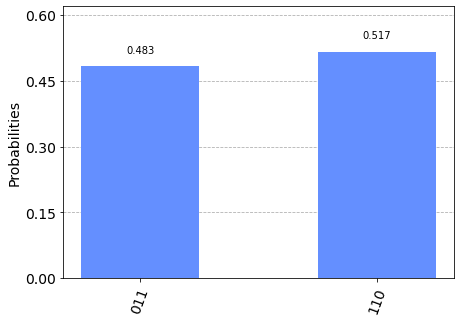

In [18]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(q_grover, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [19]:
# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_q_grover = transpile(q_grover, backend, optimization_level=3)
job = backend.run(transpiled_q_grover)
job_monitor(job, interval=2)

ibmqfactory.load_account:WARNING:2022-07-20 13:14:08,911: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_manila
Job Status: job has successfully run


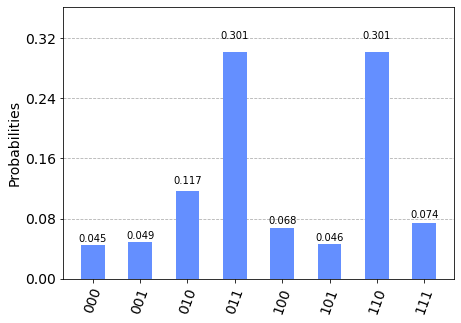

In [20]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

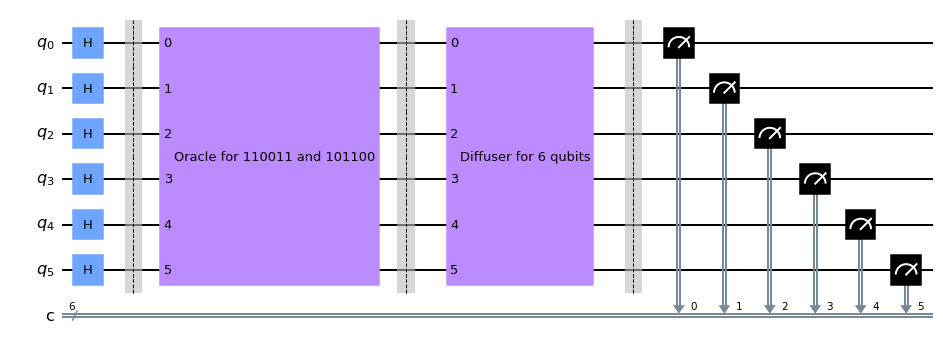

In [59]:
# Now, we're going to run a 6-Qubit Grover search on 2 values: 110011 and 001100:
n = 6
m = 1

def oracle_six():
    q_oracle = QuantumCircuit(n)
    
    # Firstly, for 110011:
    for i in [2,3]:
        q_oracle.x(i)
    q_oracle.h(n-1)
    
    
    q_oracle.mct([0,1,2,3,4], 5)
    
    for i in [2,3]:
        q_oracle.x(i)
    q_oracle.h(n-1)
    
    for i in [0,1,4]:
        q_oracle.x(i)
    q_oracle.h(5)
    
    q_oracle.mct([0,1,2,3,4], 5)
    
    for i in [0,1,4]:
        q_oracle.x(i)
    q_oracle.h(5)
    
    q_oracle = q_oracle.to_gate()
    q_oracle.name = "Oracle for 110011 and 101100"
    
    return q_oracle

def diffuser_six():
    q_diffuser = QuantumCircuit(n)
    
    for i in range(n):
        q_diffuser.h(i)
    
    for i in range(n):
        q_diffuser.x(i)
        
    q_diffuser.mct([0,1,2,3,4], 5)
    
    for i in range(n):
        q_diffuser.x(i)
        
    for i in range(n):
        q_diffuser.h(i)
        
    q_diffuser = q_diffuser.to_gate()
    q_diffuser.name = "Diffuser for 6 qubits"
    
    return q_diffuser

q_grover = QuantumCircuit(n,n)

for i in range(n):
    q_grover.h(i)
    
q_grover.barrier()

q_grover.append(oracle_six(),range(n))    

q_grover.barrier()

#cIterations = math.floor( (np.pi / 4.0) * np.sqrt((n/m)) )
cIterations = 1

for i in range(cIterations):
    q_grover.append(diffuser_six(),range(n))
    q_grover.barrier()
    
    
for i in range(n):
    q_grover.measure(i,i)
    
q_grover.draw()
    

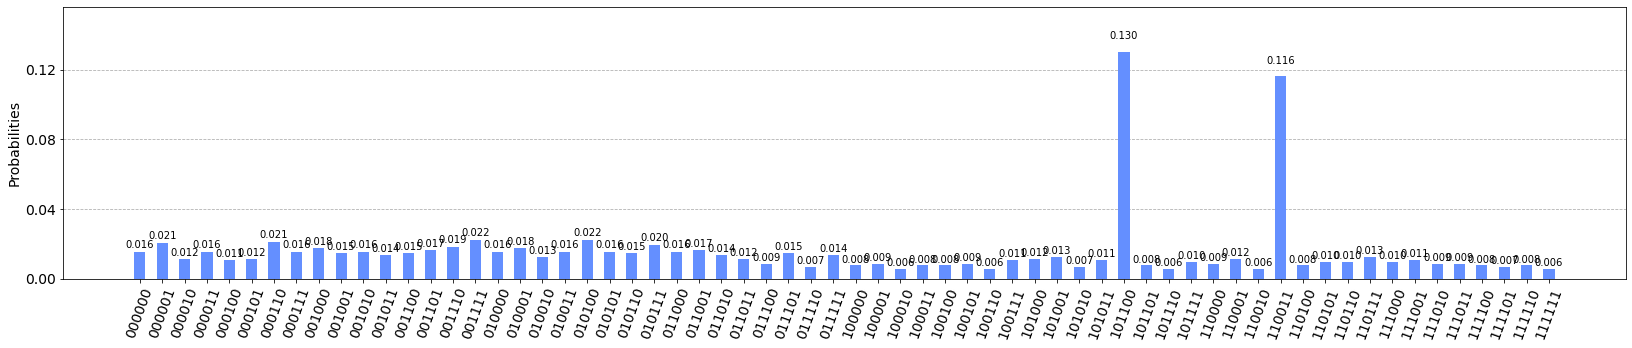

In [60]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(q_grover, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts, (28,5))

In [61]:
# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_q_grover = transpile(q_grover, backend, optimization_level=3)
job = backend.run(transpiled_q_grover)
job_monitor(job, interval=2)

ibmqfactory.load_account:WARNING:2022-07-20 14:17:49,619: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibm_oslo
Job Status: job has successfully run
